Model the window correction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nbodykit.lab as nb
import nbodykit
import fitsio as ft
from time import time
from   glob import glob
import mcfit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
plt.rc('font', size=20)

In [3]:
from scipy.special import legendre

def RR_to_ell(RR, mu_bins, ell):
    mu_mid       = 0.5*(mu_bins[:-1]+mu_bins[1:])
    legendre_pol = (2*ell+1.)*legendre(ell)(mu_mid)
    mu_diff      = np.diff(mu_bins) 
    result       = RR * legendre_pol * mu_diff
    print(result.shape)
    RR_ell       = np.sum(result, axis=-1) / np.sum(mu_bins)
    return RR_ell    

def plot_RRellr(RR, ells=[0, 2, 4]):    
    for ell in ells:
        x   = RR.pairs.edges['r']
        y   = RR_to_ell(RR.pairs['wnpairs'], RR.pairs.edges['mu'], ell)
        dx  = np.diff(x)
        xc  = 0.5*(x[1:]+x[:-1])
        vol = 4*np.pi*xc**2*dx    
        y  /= vol
        #print(y[0])
        #y /= y[3]
        plt.plot(xc, y, label='ell=%d'%ell)
    plt.legend()
    plt.xscale('log')
    plt.xlim(10, 4e3)
    #plt.ylim(-1.5, 1.1)
    # plt.xlim(xmin=1)
    

def read_florian():    
    lbls = 'W^0_0(k) W^0_1(k) W^0_2(k) W^0_3(k) W^0_4(k) W^1_0(k)'\
        +' W^1_1(k) W^1_2(k) W^1_3(k) W^1_4(k) W^2_0(k) W^2_1(k) W^2_2(k) W^2_3(k) W^2_4(k) Nmodes'
    tlb = lbls.split(' ')    
    d = np.loadtxt('/home/mehdi/data/eboss/v6/win_eBOSS_DR16_QSO_v6_NGC_TSC_600_600_600_10000_merged.dat', 
                   skiprows=30)
    w_dicts = {}
    for i, j in enumerate(range(2, 17)):
        k = d[:, 0]
        w = d[:, j]
        w_dicts[tlb[i]] = w
    return k, w_dicts    



def plot_W0ellr(k, w_dicts, ax=None, ells=[0, 2, 4]):
    Klog = np.logspace(np.log10(k.min()), np.log10(2.0), num=1024, endpoint=True)
    if ax is None:
        fig,ax = plt.subplots(figsize=(8, 6))
    for ell in ells:
        wius = IUS(k, w_dicts['W^0_%d(k)'%ell], ext=1)
        wk   = wius(Klog)        
        print(Klog[-10:], wk[-10:])
        #for i in range(Klog.size):
        #    print([Klog[i], wk[i]])
        #break
        r, wr = mcfit.P2xi(Klog, l=ell)(wk)
        sf = 1 if ell==2 else 1
        ax.plot(r, sf*wr, label=r'$W^0_%d$'%ell)
    ax.axhline(0.0, color='k')
    ax.set_xscale('log')
    ax.set_xlim(10, 4e3)
    # plt.ylim(0, 2.e-10)
    ax.set_xlabel('r')
    ax.legend(fontsize=20)
    
    
def plot_W0ellk(k, w_dicts, ax=None, ells=[0, 2, 4]):
    if ax is None:fig, ax = plt.subplots(figsize=(8, 6))
    for l in ells:
        w = w_dicts['W^0_%d(k)'%l]
        ax.plot(k, w, label=r'$W^0_%d$'%l, marker='.')

    #ax.axhline(0.0, color='k')
    ax.set_xscale('log')
    #ax.set_xlim(1.e-4, 2e-2)
    #ax.set_xlim(1.e-4, 0.5)
    #plt.ylim(0, 2.e-10)
    ax.set_xlabel('k')
    ax.legend(fontsize=20)    
    
    
# def plot_RRr(RR):
#     dr = np.diff(edges)
#     plt.plot(edges[:-1], RR1d.pairs['wnpairs']/ ((4*np.pi*edges[:-1]**2*dr)))
#     plt.xscale('log')
#     plt.xlim(xmin=1)    
    
    
def plot_RRrmu(RR):
    for j, mu_j in enumerate(RR.pairs.edges['mu'][:-1]):
        #print(j)
        plt.plot(RR.pairs.edges['r'][:-1], RR.pairs['wnpairs'][:, j], label=r'$\mu$=%.1f'%mu_j)
    plt.legend(bbox_to_anchor=(1.1, 1.1))
    plt.ylabel('RR(r)')
    plt.xlabel('r')        

Use SurveyDataPairCount and use Nmu= 100
Inside this SurveyDataPairCount, modify the option for 1d.
And made mode 2d

Make your code so that it addes all different mu bins aftermultiply with Legendre_ell(mu)


## Florian's vs. HJ's Paircount

In [4]:
class WINDOW(object):
    def __init__(self, path2file='/C/sheejong/Shared/eBOSS_QSO_clustering_NGC_v6.ran'):
        self.RR = nb.SurveyDataPairCount.load(path2file)
    def __call__(self, ell):
        print('ell = %d'%ell)
        x   = self.RR.pairs.edges['r']
        y   = RR_to_ell(self.RR.pairs['wnpairs'], 
                        self.RR.pairs.edges['mu'], ell)
        dx  = np.diff(x)
        xc  = 0.5*(x[1:]+x[:-1])
        vol = 4*np.pi*xc**2*dx    
        y  /= vol
        self.r  = xc
        self.wr = y
        #return xc, y        
    def Wr2Wk(self, rmin=None, rmax=None, zero=False):
        if rmin is None:
            rmin = self.r.min()
        if rmax is None:
            rmax = self.r.max()
        rgrid   = np.logspace(np.log10(rmin), np.log10(rmax), 
                              self.r.size, endpoint=True)  
        if zero:self.wr[self.r<5] = 0.0
        w_inter = IUS(self.r, self.wr, ext=1)
        #w_inter.set_smoothing_factor(100)
        wr      = w_inter(rgrid)
        k, wk   = mcfit.xi2P(rgrid)(wr)
        self.k  = k
        self.wk = wk
        self.re = rgrid
        self.wre = wr

In [5]:
class WINDOWf(object):
    def __init__(self):
        k, w_dicts = read_florian()
        self.k     = k
        self.wdict = w_dicts
        
    def __call__(self, ell):
        self.ell = ell
        self.wk  = self.wdict['W^0_%d(k)'%ell]
                             
    def Wk2Wr(self, kmin=None, kmax=None):
        if kmin is None:
            kmin = self.k.min()
        if kmax is None:
            kmax = self.k.max()
        klog = np.logspace(np.log10(kmin), np.log10(kmax), 
                           num=self.k.size, endpoint=True)

        w_interpolated = IUS(self.k, self.wk, ext=1)
        wk   = w_interpolated(klog)        
        r,wr = mcfit.P2xi(klog, l=self.ell)(wk)           
        self.r = r
        self.wr= wr                
        self.ke  = klog
        self.wke = wk

ell = 0
(99, 20)


[]

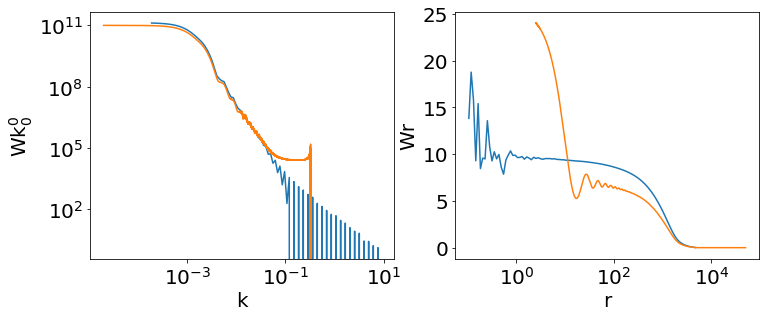

In [82]:
ell       = 0
paircount = WINDOW()
paircount(ell)
paircount.Wr2Wk()

fourier   = WINDOWf()
fourier(ell)
fourier.Wk2Wr()


plt.figure(figsize=(12, 10))
plt.subplot(222)
plt.plot(paircount.r, paircount.wr)
plt.plot(fourier.r, 1.0e11*fourier.wr)
plt.xlabel('r')
plt.ylabel('Wr')
plt.xscale('log')

plt.subplot(221)
plt.plot(paircount.k, paircount.wk)
plt.plot(fourier.k,   1.0e11*fourier.wk)
plt.xlabel('k')
plt.ylabel(f'Wk$^{0}_{ell}$')
plt.loglog()

ell = 2
(99, 20)


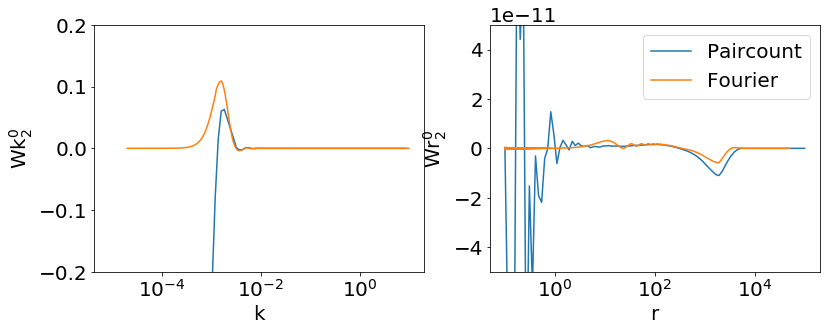

In [79]:
ell       = 2
paircount = WINDOW()
paircount(ell)
paircount.Wr2Wk(rmin=0.1, rmax=100000.)

fourier   = WINDOWf()
fourier(ell)
fourier.Wk2Wr(kmax=10.)
plt.figure(figsize=(13, 10))

plt.subplot(221)
plt.plot(paircount.k, 1.0e-11*paircount.wk)
plt.plot(fourier.ke,   fourier.wke)
plt.xlabel('k')
plt.ylabel(f'Wk$^{0}_{ell}$')
plt.xscale('log')
plt.ylim(-0.2, 0.2)


plt.subplot(222)
plt.plot(paircount.re, 1.0e-11*paircount.wre, label='Paircount')
plt.plot(fourier.r,   fourier.wr, label='Fourier')
plt.xlabel('r')
plt.ylabel(f'Wr$^{0}_{ell}$')
plt.xscale('log')
plt.ylim(-0.5e-10, 0.5e-10)
plt.legend()
# #plt.loglog()

In [7]:
fourier.wk

array([0.02654367, 0.05446552, 0.08700373, ..., 0.        , 0.        ,
       0.        ])

ell = 2
(99, 20)
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.0000

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/mcfit/mcfit.py:125: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/mcfit/mcfit.py:219: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


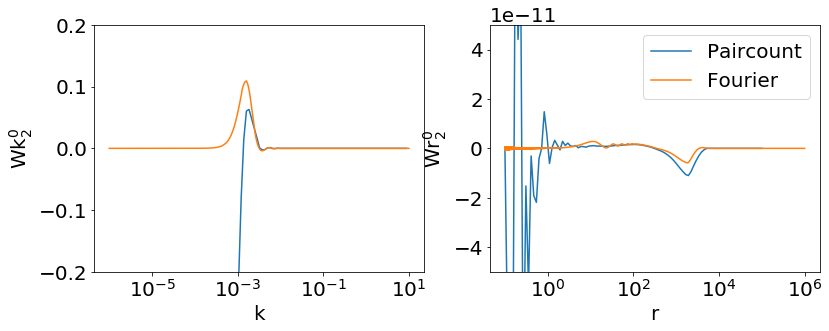

In [8]:
ell       = 2
paircount = WINDOW()
paircount(ell)
paircount.Wr2Wk(rmin=0.1, rmax=100000.)

fourier   = WINDOWf()
fourier(ell)
fourier.Wk2Wr(kmin=1.e-6, kmax=10.)
plt.figure(figsize=(13, 10))

plt.subplot(221)
plt.plot(paircount.k, 1.0e-11*paircount.wk)
plt.plot(fourier.ke,   fourier.wke)
plt.xlabel('k')
plt.ylabel(f'Wk$^{0}_{ell}$')
plt.xscale('log')
plt.ylim(-0.2, 0.2)


plt.subplot(222)
plt.plot(paircount.re, 1.0e-11*paircount.wre, label='Paircount')
plt.plot(fourier.r,   fourier.wr, label='Fourier')
plt.xlabel('r')
plt.ylabel(f'Wr$^{0}_{ell}$')
plt.xscale('log')
plt.ylim(-0.5e-10, 0.5e-10)
plt.legend()
# #plt.loglog()

In [ ]:
pa

In [85]:
ell       = 1
paircount = WINDOW()
paircount(ell)
paircount.Wr2Wk(rmin=0.1, rmax=100000.)

fourier   = WINDOWf()
fourier(ell)
fourier.Wk2Wr(kmin=1.e-6, kmax=10.)
plt.figure(figsize=(13, 10))

plt.subplot(221)
plt.plot(paircount.k, 1.0e-11*paircount.wk)
plt.plot(fourier.ke,   fourier.wke)
plt.xlabel('k')
plt.ylabel(f'Wk$^{0}_{ell}$')
plt.xscale('log')
plt.ylim(-0.2, 0.2)


plt.subplot(222)
plt.plot(paircount.re, 1.0e-11*paircount.wre, label='Paircount')
plt.plot(fourier.r,   fourier.wr, label='Fourier')
plt.xlabel('r')
plt.ylabel(f'Wr$^{0}_{ell}$')
plt.xscale('log')
plt.ylim(-0.5e-10, 0.5e-10)
plt.legend()
# #plt.loglog()

ell = 1
(99, 20)


TypeError: 1st argument must be a real sequence 1

(1e-15, 12)

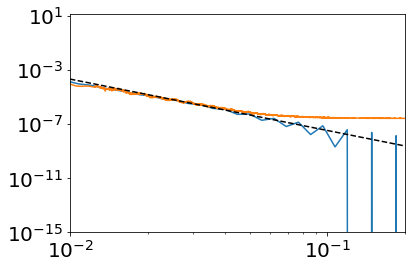

In [11]:
plt.plot(xik, 1.e-11*pk)
plt.plot(k, w_dicts['W^0_0(k)'])
plt.plot(k, 5.e-12*np.power(k, -3.8), 'k--')
plt.loglog()
plt.xlim(1.e-2, 2.e-1)
plt.ylim(1.e-15, 12)

In [26]:
funct = lambda x:5.e-12*np.power(x, -3.8)
myk   = k.copy()
dk    = myk[1]-myk[0] 
mask  = myk>=2.e-2
myw   = w_dicts['W^0_0(k)'].copy()
mykc  = myk[mask]
myw[mask] = funct(mykc)

In [33]:
kextra = np.arange(1.001*mykc.max(), 10., dk)
wextra = funct(kextra)

myk_e  = np.concatenate([myk, kextra])
myw_e  = np.concatenate([myw, wextra])

(1e-15, 12)

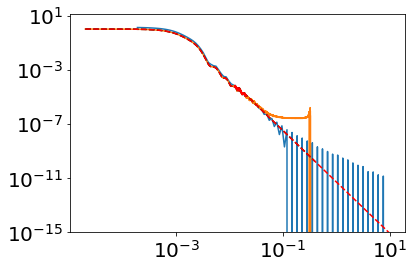

In [34]:
plt.plot(xik, 1.e-11*pk)
plt.plot(k, w_dicts['W^0_0(k)'])
plt.plot(myk, myw, 'k--')
plt.plot(myk_e, myw_e, 'r--')
plt.loglog()
#plt.xlim(1.e-2, 2.e-1)
plt.ylim(1.e-15, 12)

In [36]:
def Wk2Wr(k, w):
    klog = np.logspace(np.log10(k.min()), np.log10(k.max()), 
                       num=k.size, endpoint=True)
    
    w_interpolated = IUS(k, w, ext=1)
    wk   = w_interpolated(klog)        
    return mcfit.P2xi(klog, l=0)(wk)    

In [37]:
rWr = Wk2Wr(myk_e, myw_e)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/mcfit/mcfit.py:125: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/mcfit/mcfit.py:219: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


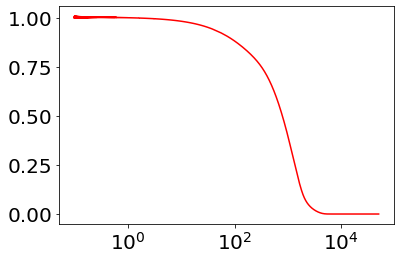

In [46]:
# plt.plot(xc, y)
plt.plot(rWr[0], 1.0e11*rWr[1]/7.32387230, 'r-')
plt.xscale('log')


[1.80734776 1.82780269 1.84848911 1.86940966 1.89056698 1.91196375
 1.93360268 1.95548651 1.97761802 2.        ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.80734776 1.82780269 1.84848911 1.86940966 1.89056698 1.91196375
 1.93360268 1.95548651 1.97761802 2.        ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.80734776 1.82780269 1.84848911 1.86940966 1.89056698 1.91196375
 1.93360268 1.95548651 1.97761802 2.        ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


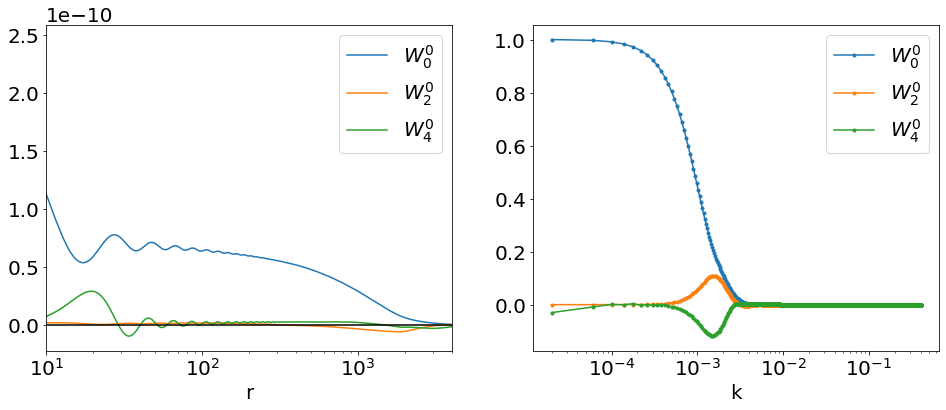

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
plot_W0ellr(k, w_dicts, ax=ax[0])
plot_W0ellk(k, w_dicts, ax=ax[1])
# ax[1].axis([8.e-3, 2.e-2, 0.1, 0.1])

## read the randoms catalog

In [19]:
#randoms = ft.read('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits', lower=True)
randoms = ft.read('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6_100k.ran.fits', lower=True)
print(randoms.dtype.names)
# randoms = np.random.choice(randoms, size=10000, replace=False)
randoms = nb.ArrayCatalog(randoms)
randoms['Weight'] = randoms['weight_cp']*randoms['weight_noz']*randoms['weight_systot']*randoms['weight_fkp']

def run():
    t0 = time()    
    edges = np.logspace(np.log10(0.1), np.log10(5000.0), 100)
    # edges = np.linspace(0.001, 5000.0, 100)
    cosmo = nb.cosmology.Planck15
    RR    = nb.SurveyDataPairCount('2d', randoms, edges, Nmu=20, cosmo=cosmo, 
                                   ra='ra', dec='dec', redshift='z', weight='Weight',
                                   show_progress=1)
    print('took {} sec'.format(time()-t0))
    return RR
RR = run()
RR.save('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6_100k.RR.ran.json')

took 266.39410305023193 sec


0.0
0.0
0.0


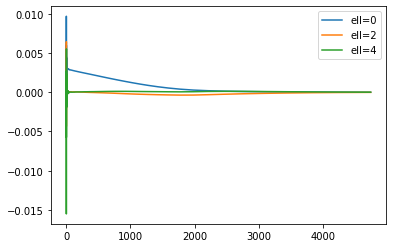

In [27]:
for ell in [0, 2, 4]:
    x   = RR.pairs.edges['r']
    y   = RR_to_ell(RR.pairs['wnpairs'], RR.pairs.edges['mu'], ell)
    dx  = np.diff(x)
    xc  = 0.5*(x[1:]+x[:-1])
    vol = 4*np.pi*xc**2*dx    
    y  /= vol
    print(y[0])
    plt.plot(xc, y, label='ell=%d'%ell)
plt.legend()
# plt.xscale('log')
# plt.xlim(xmin=1)